<a href="https://colab.research.google.com/github/chaewoncutie/Algorithm-Tests/blob/main/latest%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn hdbscan

In [15]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, precision_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud
import numpy as np
import umap
import hdbscan
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from IPython import get_ipython
from IPython.display import display

In [16]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
file_name = next(iter(uploaded))
df = pd.read_json(file_name, lines=True)

# Count rows and columns of the original dataset
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")

# Display the head of the original dataset
display(df.head())

# Remove white space or empty strings and make them null
df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)

# Count and identify null values in the original dataset
null_counts = df.isnull().sum()
print(f"Null values in each column:\n{null_counts}")

# Count duplicated rows in the original dataset
duplicate_count = df.duplicated().sum()
print(f"Number of duplicated rows: {duplicate_count}")

# Drop rows with null values in 'headline' or 'short_description' from the original dataset
df = df.dropna(subset=['headline', 'short_description'])

# Drop all duplicated rows from the original dataset
df = df.drop_duplicates()

# Retain only rows with dates from 2017 to 2022
df = df[df['date'].dt.year.isin(range(2017, 2023))]

# Count rows and columns after cleaning the original dataset
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (2).json
Number of rows in original dataset: 209527
Number of columns in original dataset: 6


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


<ipython-input-4-6c2c56963aef>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.7, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
svd = TruncatedSVD(n_components=min(X.shape[1],3800) , random_state=42)
X_svd = svd.fit_transform(X)

umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [10]:
wcss = []
silhouette_scores = []
for k in range(2, 21):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_normalized)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_normalized, kmeans_labels))

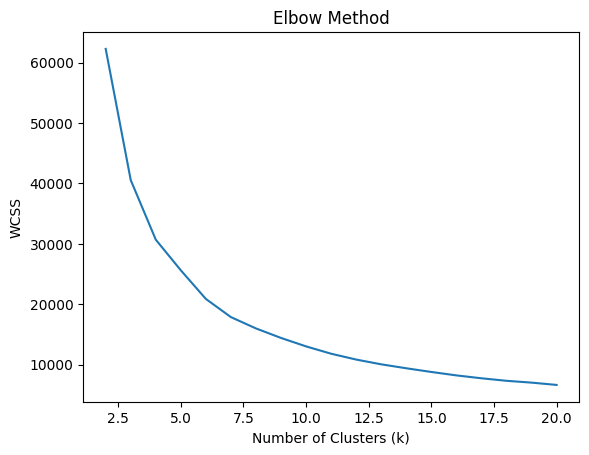

In [11]:
# Plot the elbow method
plt.plot(range(2, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

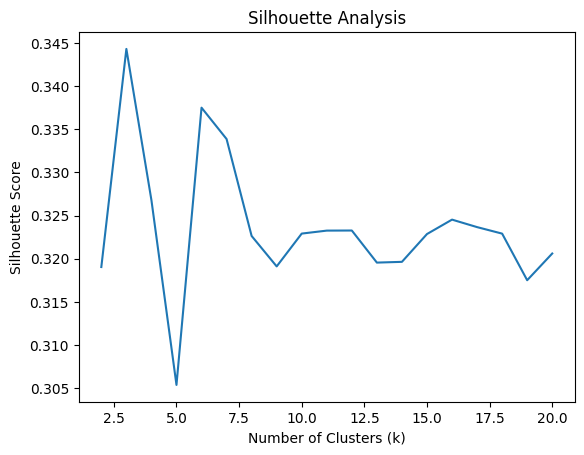

In [12]:
# Plot silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# Hyperparameter Tuning for DBSCAN
param_grid = {'eps': [0.1, 0.2, 0.3, 0.4, 0.5], 'min_samples': [3, 5, 7, 9]}
best_score = -1
best_params = {}

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    dbscan_labels = dbscan.fit_predict(X_normalized)

    if len(set(dbscan_labels)) > 1:  # Check if more than one cluster is found
        score = silhouette_score(X_normalized, dbscan_labels)
        if score > best_score:
            best_score = score
            best_params = params

print(f"Best DBSCAN parameters: {best_params}")
print(f"Best DBSCAN silhouette score: {best_score}")

In [ ]:
# Apply DBSCAN with the best parameters
dbscan = DBSCAN(**best_params)
dbscan_labels = dbscan.fit_predict(X_normalized)
df['cluster_dbscan'] = dbscan_labels

In [ ]:
# Evaluate Clustering using multiple metrics
metrics = {
    'kmeans': {},
    'gmm': {},
    'dbscan': {},
    'hdbscan': {}
}

for k in range(10, 21):
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_normalized)
    metrics['kmeans'][k] = {
        'silhouette': silhouette_score(X_normalized, kmeans_labels),
        'davies_bouldin': davies_bouldin_score(X_normalized, kmeans_labels),
        'calinski_harabasz': calinski_harabasz_score(X_normalized, kmeans_labels),
        'precision': precision_score(kmeans_labels, kmeans_labels, average='macro', zero_division=1),
        'adjusted_rand': adjusted_rand_score(kmeans_labels, kmeans_labels),
        'nmi': normalized_mutual_info_score(kmeans_labels, kmeans_labels),
        'similarity': cosine_similarity(X_normalized).mean()
    }
    df[f'cluster_kmeans_{k}'] = kmeans_labels

In [ ]:
# DBSCAN (using best parameters)
metrics['dbscan'] = {
    'silhouette': silhouette_score(X_normalized, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
    'davies_bouldin': davies_bouldin_score(X_normalized, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
    'calinski_harabasz': calinski_harabasz_score(X_normalized, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
    'adjusted_rand': adjusted_rand_score(dbscan_labels, dbscan_labels),
    'nmi': normalized_mutual_info_score(dbscan_labels, dbscan_labels),
    'similarity': cosine_similarity(X_normalized).mean()
}

In [ ]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_normalized)

plt.figure(figsize=(10, 6))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar()
plt.show()

def generate_wordcloud(cluster_num, cluster_labels, data):
    # Filter data for the specific cluster
    cluster_data = data[cluster_labels == cluster_num]

    # Combine text from all documents in the cluster
    text = ' '.join(cluster_data['filtered_text'].astype(str).tolist())

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.show()

# Example usage:
for cluster_num in range(k):  # Assuming k=15
    generate_wordcloud(cluster_num, kmeans_labels, df)

# Print clustering metrics
print("Clustering Metrics:")
for method, scores in metrics.items():
    print(method.upper(), scores)